### 폴더 생성

In [1]:
! mkdir -p./models
! mkdir -p ./images

mkdir: invalid option -- '.'
Try 'mkdir --help' for more information.


### 이미지 다운로드

In [2]:
# 기본 제공 이미지입니다. 여러분만의 이미지로 바꿔보세요!
! wget https://d3s0tskafalll9.cloudfront.net/media/images/E-14-3.max-800x600_KwXP73b.png
! mv E-14-3.max-800x600_KwXP73b.png ./images/my_image.png

--2026-01-19 10:21:59--  https://d3s0tskafalll9.cloudfront.net/media/images/E-14-3.max-800x600_KwXP73b.png
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 3.169.137.123, 3.169.137.128, 3.169.137.45, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|3.169.137.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662087 (647K) [image/png]
Saving to: ‘E-14-3.max-800x600_KwXP73b.png’

E-14-3.max-800x600_ 100%[===================>] 646.57K  --.-KB/s    in 0.02s   

2026-01-19 10:21:59 (35.9 MB/s) - ‘E-14-3.max-800x600_KwXP73b.png’ saved [662087/662087]



### 패키지 다운로드

In [3]:
!pip install opencv-python pixellib

### 패키지 선언

In [4]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


### Step 1. 인물모드 직접 해 보기

원본 고양이 이미지 크기: (720, 1280, 3)
배경(사막) 이미지 크기: (720, 1080, 3)


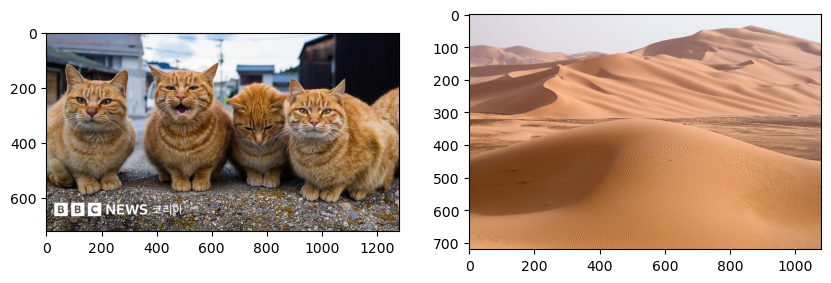

In [5]:
cat_img_path = "./images/cat.png"  # 고양이 이미지를 준비해주세요
sand_img_path = "./images/sand.png"  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [6]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


추론 마스크 크기 (Before Resize): (520, 520)


In [7]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (720, 1280)


In [8]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


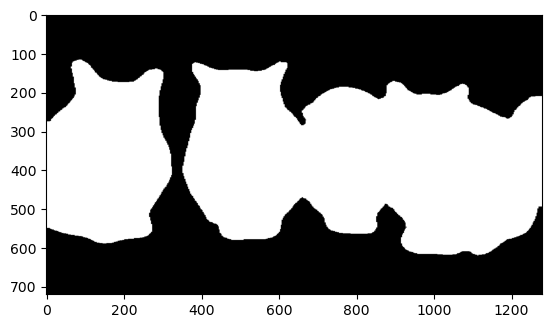

In [9]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

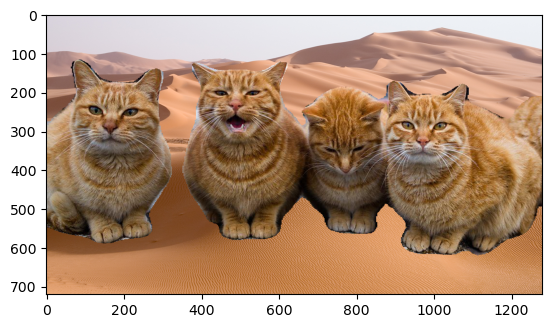

In [10]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

### Step 2. 사진에서 문제점 찾기

In [11]:
# case1 원본 이미지에서 사람과 배경의 구분이 불명확할 때
img_path = "./images/karina.jpg"  # 고양이 이미지를 준비해주세요
sand_img_path = "./images/sand.png"  # 사막 배경 이미지를 준비해주세요

img = cv2.imread(_img_path)
sand_img = cv2.imread(sand_img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

NameError: name '_img_path' is not defined

In [ ]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

In [ ]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

In [ ]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

In [ ]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

In [ ]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (img.shape[1], img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

### Step 3. 해결 방법을 제안해 보기